# Imports

In [277]:
# %pip install numpy
# %pip install yfinance
# %pip install matplotlib
# %pip install scipy
# %pip install seaborn

In [278]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.stats import beta
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Coffee Historic Price Movement

In [279]:
s = yf.download('KC=F', '2016-1-1', '2023-4-1')['Adj Close']

[*********************100%***********************]  1 of 1 completed


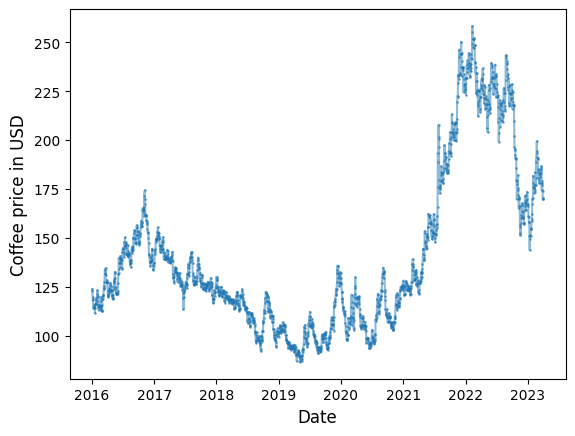

In [280]:
fig, ax = plt.subplots()

ax.plot(s, marker='o', alpha=0.5, ms=1)
ax.set_ylabel('Coffee price in USD', fontsize=12)
ax.set_xlabel('Date', fontsize=12)

plt.show()

## Brazilian Weather Data

### First data set: measuring station codes

In [281]:
first_df = pd.read_csv('FirstDataSet/automatic_stations_codes_2000_2021.csv', sep=';')
first_df_copy = first_df.copy()
print(list(first_df_copy.columns)) 

['REGIAO', 'UF', 'ESTACAO', 'CODIGO', 'LATITUDE', 'LONGITUDE', 'ALTITUDE']


We just want the stations in São Paulo, Rondônia and Paraná.
The respective UF(Unidade da Federação) codes are SP, RO and PR

In [282]:
UF_values = ['SP', 'RO', 'PR']
first_df_specUF = first_df.loc[first_df['UF'].isin(UF_values)]
print(first_df_specUF)

    REGIAO  UF                 ESTACAO CODIGO   LATITUDE  LONGITUDE  ALTITUDE
1       SE  SP               CRIOSFERA   C891 -84.000000 -79.494167   1285.00
13      SE  SP                   BAURU   A705 -22.358056 -49.028889    666.00
33      SE  SP        CAMPOS DO JORDAO   A706 -22.750278 -45.603889   1642.00
34      SE  SP                  FRANCA   A708 -20.580000 -47.380000   1026.00
54      SE  SP     PRESIDENTE PRUDENTE   A707 -22.120000 -51.400000    435.55
..     ...  ..                     ...    ...        ...        ...       ...
563     SE  SP                    TUPA   A768 -21.927222 -50.490278    498.00
564     SE  SP      CACHOEIRA PAULISTA   A769 -22.688889 -45.005556    586.00
597     SE  SP  SAO PAULO - INTERLAGOS   A771 -23.724722 -46.678056    771.00
607     SE  SP               SAO SIMAO   A770 -21.461111 -47.579444    620.00
608      S  PR                 GOIOERE   A825 -24.158333 -53.030556    452.34

[77 rows x 7 columns]


We now want all the individual station codes

In [283]:
station_ids = sorted(first_df_specUF['CODIGO'].values)
print(station_ids)

['A701', 'A705', 'A706', 'A707', 'A708', 'A711', 'A712', 'A713', 'A714', 'A715', 'A716', 'A718', 'A725', 'A726', 'A727', 'A728', 'A729', 'A733', 'A734', 'A735', 'A736', 'A737', 'A738', 'A739', 'A740', 'A741', 'A744', 'A746', 'A747', 'A748', 'A753', 'A755', 'A762', 'A763', 'A764', 'A765', 'A766', 'A767', 'A768', 'A769', 'A770', 'A771', 'A807', 'A818', 'A819', 'A820', 'A821', 'A822', 'A823', 'A824', 'A825', 'A835', 'A842', 'A843', 'A846', 'A847', 'A849', 'A850', 'A855', 'A869', 'A871', 'A872', 'A873', 'A874', 'A875', 'A876', 'A925', 'A938', 'A939', 'A940', 'B803', 'B804', 'B806', 'C891', 'S101', 'S104', 'S110']


### Second data set: weather data measured by the previously stated stations
In the first run the following two blocks were run and then the resulting filtered csv was saved. In the following runs, we just import that saved csv directly (included in this repo) to save time and computer power.

In [284]:
# #T he Kaggle states this csv file has 60452376 lines, so we want to know every 1M processed lines
# processed_lines = 0

# # Initialize an empty list to store the filtered data
# filtered_data = []

# # Read the CSV file in chunks to avoid overload
# for chunk in pd.read_csv('FirstDataSet/automatic_weather_stations_inmet_brazil_2000_2021.csv', sep=';', chunksize=1000):  # Adjust chunksize as needed
#     #filter the chunk
#     filtered_chunk = chunk[chunk['ESTACAO'].isin(station_ids)]
#     #append the filtered chunk to the list
#     filtered_data.append(filtered_chunk)
#     processed_lines +=1000
#     if processed_lines % 1_000_000 == 0:
#         print(processed_lines)

# # Concatenate all filtered chunks into a single DF
# filtered_df = pd.concat(filtered_data, ignore_index=True)

In [285]:

# # Save the filtered data to a CSV file
# filtered_df.to_csv('FilteredData/filtered_data.csv', index=False)  

In [286]:
# Get the previously processed data
filtered_df = pd.read_csv('FilteredData/filtered_data.csv', sep=',')

### Now we search for outliers and clean the data a bit to ensure better results

In [287]:
print(filtered_df.columns)

Index(['ESTACAO', 'DATA (YYYY-MM-DD)', 'HORA (UTC)',
       'PRECIPITACAO TOTAL HORARIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (W/m2)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (C)',
       'TEMPERATURA DO PONTO DE ORVALHO (C)',
       'TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)',
       'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)', 'VENTO, DIRECAO HORARIA (gr)',
       'VENTO, RAJADA MAXIMA (m/s)', 'VENTO, VELOCIDADE HORARIA (m/s)'],
      dtype='object')


In [288]:
# Remove the station column as it is not needed anymore
filtered_df = filtered_df.drop(columns=['ESTACAO'])

In [289]:
print(filtered_df.dtypes)

DATA (YYYY-MM-DD)                                         object
HORA (UTC)                                                 int64
PRECIPITACAO TOTAL HORARIO (mm)                          float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    float64
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          float64
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         float64
RADIACAO GLOBAL (W/m2)                                   float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)              float64
TEMPERATURA DO PONTO DE ORVALHO (C)                      float64
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                float64
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                float64
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)          float64
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)          float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 float64
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 float64
UMIDADE RELATIVA DO AR, H

In [290]:
print(filtered_df.max(axis=0))

DATA (YYYY-MM-DD)                                        2021-01-31
HORA (UTC)                                                     2300
PRECIPITACAO TOTAL HORARIO (mm)                                97.2
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)        1033.5
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)              1043.7
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)             1033.3
RADIACAO GLOBAL (W/m2)                                      11586.5
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)                    44.4
TEMPERATURA DO PONTO DE ORVALHO (C)                            39.8
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                      44.7
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                      44.0
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)                40.3
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)                35.3
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                      100.0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)        

In [291]:
print(filtered_df.min(axis=0))

DATA (YYYY-MM-DD)                                        2001-08-30
HORA (UTC)                                                        0
PRECIPITACAO TOTAL HORARIO (mm)                             -9999.0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)       -9999.0
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)             -9999.0
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)            -9999.0
RADIACAO GLOBAL (W/m2)                                      -9999.0
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)                 -9999.0
TEMPERATURA DO PONTO DE ORVALHO (C)                         -9999.0
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                   -9999.0
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                   -9999.0
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)             -9999.0
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)             -9999.0
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                    -9999.0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)        

We can assume all negative values are invalid data except for the temperature and temporal related columns

In [292]:

mask = (filtered_df.drop(columns=['DATA (YYYY-MM-DD)', 'HORA (UTC)',
                                    'TEMPERATURA DO AR - BULBO SECO, HORARIA (C)', 
                                  'TEMPERATURA DO PONTO DE ORVALHO (C)',
                                   'TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)',
                                   'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)',
                                   'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)',
                                   'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)']) >= 0).all(axis=1)
clean_df = filtered_df[mask]

In [293]:
print(clean_df.min(axis=0))

DATA (YYYY-MM-DD)                                        2001-08-31
HORA (UTC)                                                        0
PRECIPITACAO TOTAL HORARIO (mm)                                 0.0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)         825.4
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)               825.6
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)              825.1
RADIACAO GLOBAL (W/m2)                                          0.0
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)                 -9999.0
TEMPERATURA DO PONTO DE ORVALHO (C)                         -9999.0
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                   -9999.0
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                   -9999.0
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)             -9999.0
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)             -9999.0
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        7.0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)        

Now we need to remove the outliers for the temperature based columns.
For this I will use the IQR method since temperatures measurements usually do not follow Normal Distributions.

In [294]:
temp_column_names = ['TEMPERATURA DO AR - BULBO SECO, HORARIA (C)',
                'TEMPERATURA DO PONTO DE ORVALHO (C)',
                'TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)',
                'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)',
                'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)',
                'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)']

# calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = clean_df[temp_column_names].quantile(0.25)
Q3 = clean_df[temp_column_names].quantile(0.75)

# calc IQR
IQR = Q3 - Q1

# define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify appropriate rows
outliers = ((clean_df[temp_column_names] < lower_bound) | 
            (clean_df[temp_column_names] > upper_bound)).any(axis=1)

# remove outliers
clean_df = clean_df[~outliers]

In [295]:
print(clean_df.min(axis=0))

DATA (YYYY-MM-DD)                                        2001-08-31
HORA (UTC)                                                        0
PRECIPITACAO TOTAL HORARIO (mm)                                 0.0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)         825.4
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)               825.6
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)              825.1
RADIACAO GLOBAL (W/m2)                                          0.0
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)                     8.8
TEMPERATURA DO PONTO DE ORVALHO (C)                             3.5
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                       8.8
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                       8.1
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)                 4.4
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)                 2.8
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        7.0
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)        

### Get Appropriate Dataframes for study (day, month and year)

In [296]:
# Daily DF

# sum, get max or min values for each day, depending on the column and what makes more sense
final_day_df = clean_df.groupby('DATA (YYYY-MM-DD)').agg({
    'PRECIPITACAO TOTAL HORARIO (mm)': 'sum',
    'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'min',
    'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)': 'min',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)': 'min',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min',
    #assuming all other columns require the max operation
    **{col: 'max' for col in clean_df.columns if col not in [
        'DATA (YYYY-MM-DD)', 
        'PRECIPITACAO TOTAL HORARIO (mm)', 
        'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 
        'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)', 
        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)',
        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
        'HORA (UTC)']}
})

# Convert the Date column to datetime
final_day_df = final_day_df.reset_index()
final_day_df['DATA (YYYY-MM-DD)'] = pd.to_datetime(final_day_df['DATA (YYYY-MM-DD)'])
final_day_df.head(5)

,DATA (YYYY-MM-DD),PRECIPITACAO TOTAL HORARIO (mm),PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),TEMPERATURA MINIMA NA HORA ANT. (AUT) (C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (W/m2),"TEMPERATURA DO AR - BULBO SECO, HORARIA (C)",TEMPERATURA DO PONTO DE ORVALHO (C),TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIRECAO HORARIA (gr)","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,2001-08-31,4.4,944.1,18.3,13.3,36.0,947.9,948.1,2985.0,30.7,16.4,30.9,16.5,83.0,81.0,139.0,5.8,2.8
1,2001-09-01,0.0,943.3,18.7,10.1,27.0,946.5,946.6,2947.0,32.0,16.1,32.2,16.4,83.0,81.0,354.0,5.2,3.1
2,2001-09-02,0.0,942.3,18.9,11.6,29.0,946.5,946.5,2967.0,31.2,15.6,32.3,16.0,77.0,74.0,360.0,5.6,3.1
3,2001-09-03,0.0,941.0,19.3,9.7,26.0,944.7,944.9,3017.0,31.3,15.4,32.0,15.8,76.0,76.0,100.0,6.5,3.0
4,2001-09-04,0.0,942.8,18.7,9.1,23.0,945.9,945.9,2938.0,32.9,13.0,33.2,14.6,70.0,63.0,357.0,5.2,2.1


In [297]:
final_day_df_copy = final_day_df.copy()
final_day_df_copy['YEAR_MONTH'] = final_day_df_copy['DATA (YYYY-MM-DD)'].dt.to_period('M')

final_day_df_copy['YEAR_MONTH'] = final_day_df_copy['YEAR_MONTH'].astype(str)

# Monthly DF

final_month_df = final_day_df_copy.groupby('YEAR_MONTH').agg({
    'PRECIPITACAO TOTAL HORARIO (mm)': 'sum',
    'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'min',
    'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)': 'min',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)': 'min',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min',
    # Assuming all other columns require the max operation
    **{col: 'max' for col in final_day_df_copy.columns if col not in [
        'YEAR_MONTH', 
        'PRECIPITACAO TOTAL HORARIO (mm)', 
        'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 
        'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)', 
        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)',
        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
        'DATA (YYYY-MM-DD)']}
})

# Reset index to make 'YEAR_MONTH' a column again
final_month_df = final_month_df.reset_index()
final_month_df.dtypes

YEAR_MONTH                                                object
PRECIPITACAO TOTAL HORARIO (mm)                          float64
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         float64
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)                float64
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)          float64
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    float64
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          float64
RADIACAO GLOBAL (W/m2)                                   float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)              float64
TEMPERATURA DO PONTO DE ORVALHO (C)                      float64
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                float64
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)          float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 float64
UMIDADE RELATIVA DO AR, HORARIA (%)                      float64
VENTO, DIRECAO HORARIA (g

In [298]:
final_day_df_copy_copy = final_day_df_copy.copy()
final_day_df_copy['YEAR'] = final_day_df_copy['DATA (YYYY-MM-DD)'].dt.year

# Yearly DF

# Group by the extracted year
final_year_df = final_day_df_copy.groupby('YEAR').agg({
    'PRECIPITACAO TOTAL HORARIO (mm)': 'sum',
    'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'min',
    'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)': 'min',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)': 'min',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min',
    # Assuming all other columns require the max operation
    **{col: 'max' for col in final_day_df_copy.columns if col not in [
        'DATA (YYYY-MM-DD)', 
        'PRECIPITACAO TOTAL HORARIO (mm)', 
        'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 
        'TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)', 
        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)',
        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
        'YEAR']}
})

# Reset index to make 'Year' a column again
final_year_df = final_year_df.reset_index().drop(columns=['YEAR_MONTH'])
final_year_df.head(5)

,YEAR,PRECIPITACAO TOTAL HORARIO (mm),PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),TEMPERATURA MINIMA NA HORA ANT. (AUT) (C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (W/m2),"TEMPERATURA DO AR - BULBO SECO, HORARIA (C)",TEMPERATURA DO PONTO DE ORVALHO (C),TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIRECAO HORARIA (gr)","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,2001,385.6,931.0,10.0,3.2,19.0,950.9,951.0,3962.0,34.8,24.1,35.1,24.8,98.0,98.0,360.0,14.9,8.0
1,2002,1299.8,830.0,8.1,2.8,13.0,952.6,952.8,4071.0,38.7,23.6,38.7,24.3,97.0,97.0,360.0,20.3,10.2
2,2003,2310.6,829.3,8.1,2.8,13.0,972.6,972.6,4216.0,36.8,24.3,37.6,24.7,97.0,97.0,360.0,18.7,7.8
3,2004,1495.8,830.9,8.3,2.8,15.0,947.0,947.1,4500.0,34.5,23.0,35.3,23.4,97.0,97.0,360.0,16.6,8.5
4,2005,1928.4,893.8,8.4,2.8,16.0,955.9,956.0,6721.0,35.7,26.5,36.2,26.7,95.0,95.0,360.0,17.1,8.0


Now we can plot, for example the precipitation.

In [299]:
def singleYplot(x_data, y_data, dataframe, daily = False, monthly = False, yearly=False):  
     
    plt.figure(figsize=(12, 6))

    if daily:
        # Format the x-axis to show only month and year
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

        # Optionally, set major ticks to be at the start of every month
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    if monthly:
        # Convert the x_data to datetime if it's in string format
        dataframe[x_data] = pd.to_datetime(dataframe[x_data], format='%Y-%m')

    # Plotting with seaborn
    sns.lineplot(x=x_data, y=y_data, data=dataframe)
    
    if yearly:
        # Convert the x_data to datetime if it's in string format
        dataframe[x_data] = pd.to_datetime(dataframe[x_data], format='%Y')
    # Rotate the x-axis labels for better readability (optional)
    plt.xticks(rotation=45)

    plt.show()

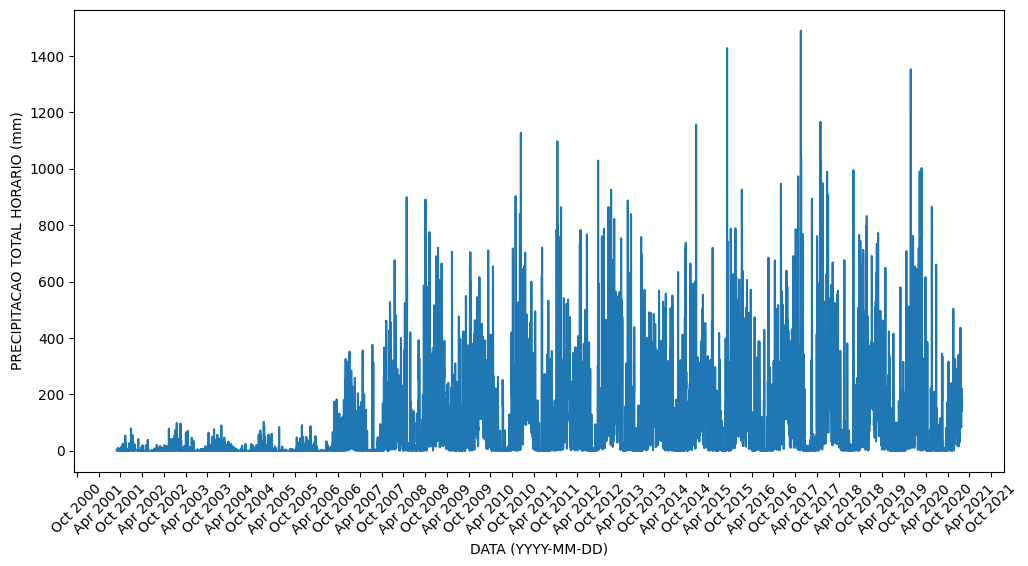

In [300]:
singleYplot('DATA (YYYY-MM-DD)', 'PRECIPITACAO TOTAL HORARIO (mm)', final_day_df, daily=True)

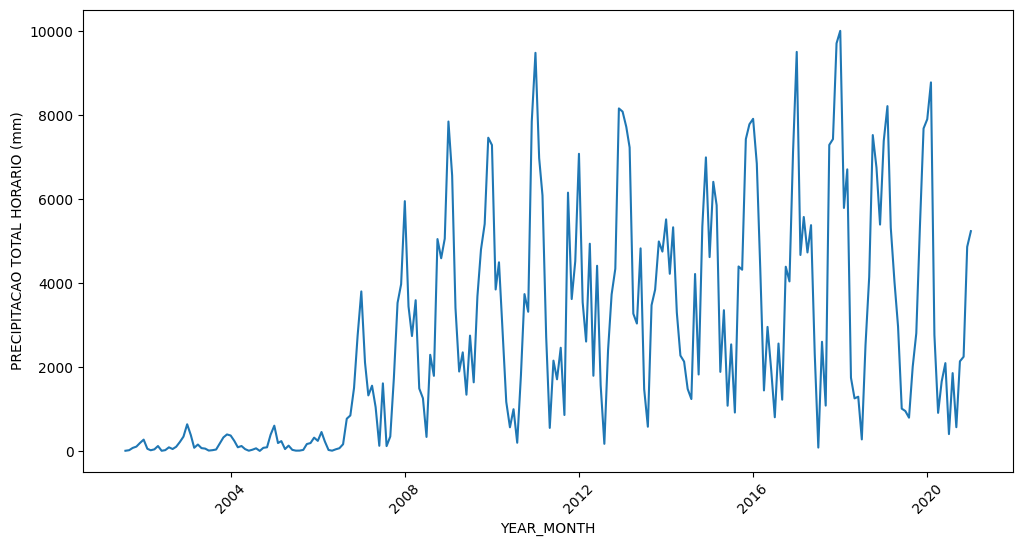

In [301]:
singleYplot('YEAR_MONTH', 'PRECIPITACAO TOTAL HORARIO (mm)', final_month_df, monthly=True)

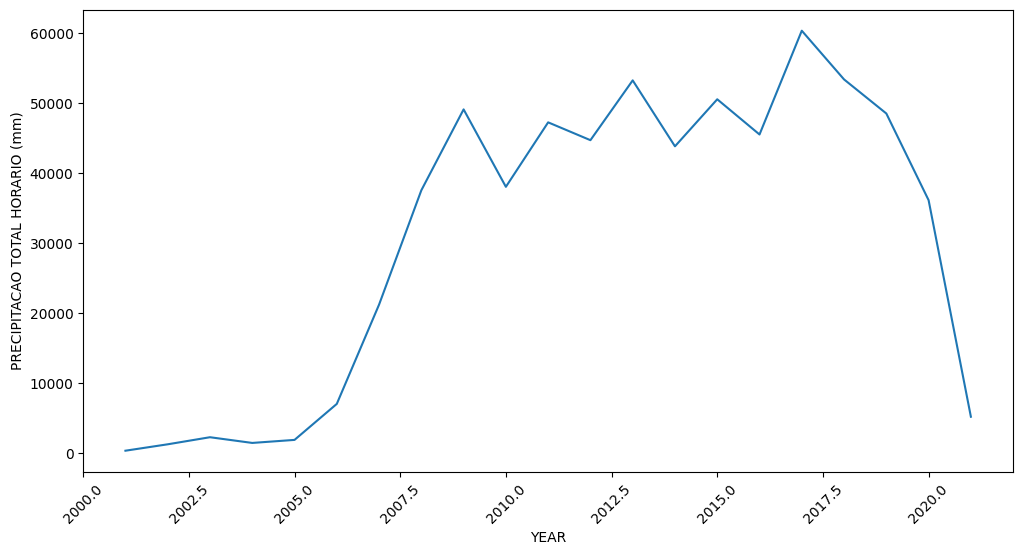

In [302]:
singleYplot('YEAR', 'PRECIPITACAO TOTAL HORARIO (mm)', final_year_df, yearly=True)

# Price vs Measurements - Plots and Conclusions

In [303]:
# Establish relevant dates
start_date = '2001-08-30'
end_date = '2021-01-31'

s = yf.download('KC=F', start_date, end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [304]:
# Convert the index of s (dates) to a column for consistency with the DataFrame
s = s.reset_index()
s['DATA (YYYY-MM-DD)'] = pd.to_datetime(s['Date'])

## For Daily Values

### Correlation Matrix to see what would be interesting to plot

DATA (YYYY-MM-DD)                                        0.345396
PRECIPITACAO TOTAL HORARIO (mm)                          0.204084
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)        -0.156033
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)               -0.253328
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)         -0.211728
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                -0.313097
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0.562479
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0.562485
RADIACAO GLOBAL (W/m2)                                   0.391698
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)              0.407791
TEMPERATURA DO PONTO DE ORVALHO (C)                      0.443148
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                0.406001
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)          0.435779
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0.409680
UMIDADE RELATIVA DO AR, HORARIA (%)                      0.419989
VENTO, DIR

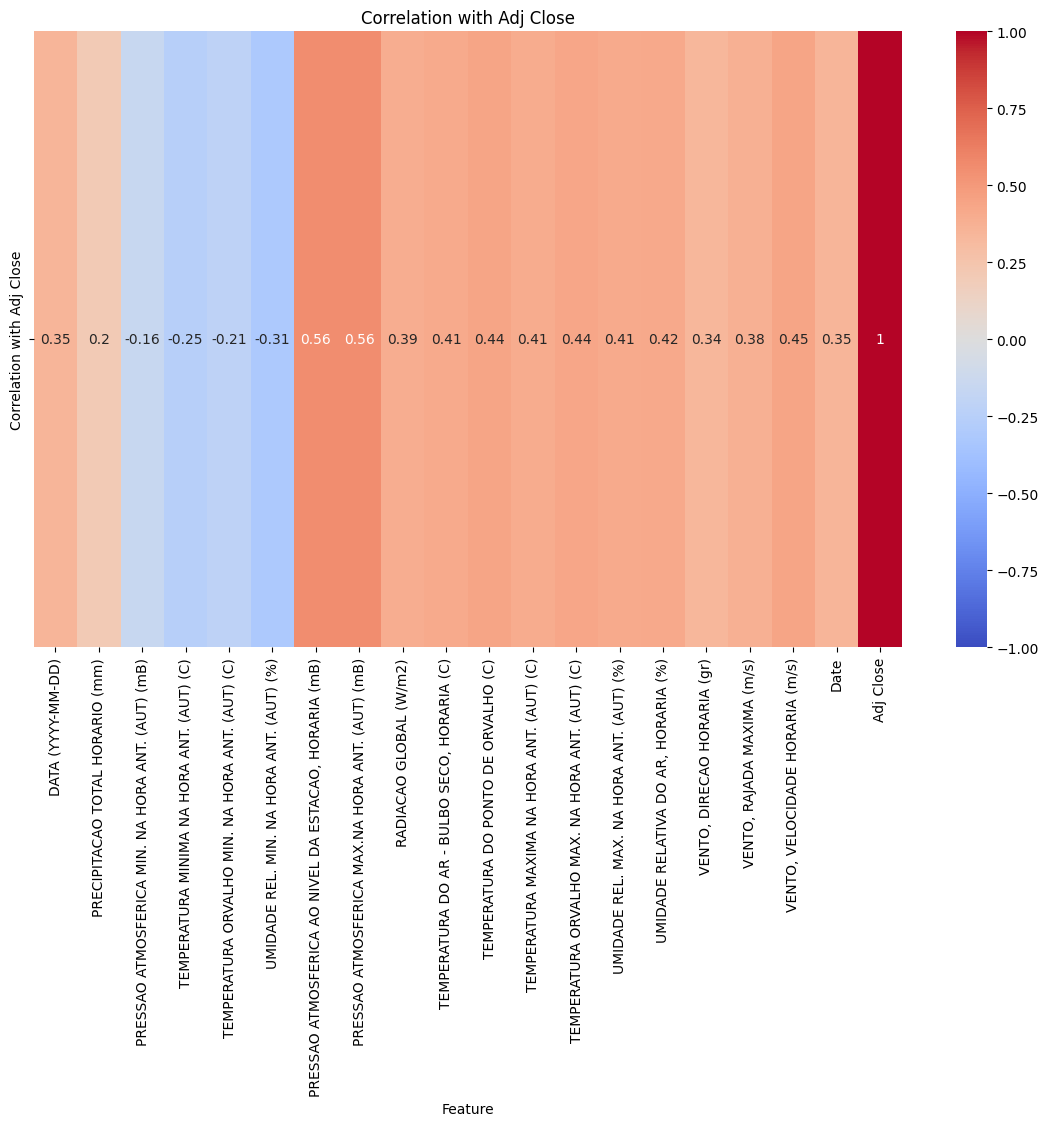

In [305]:
# Merge the two DFs on the 'Date' column
merged_df = pd.merge(final_day_df, s, on='DATA (YYYY-MM-DD)', how='inner')  #'inner' keeps only dates that are in both DFs

# Calculate correlation between 'Value' and 'Adj Close'
correlation_matrix = merged_df.corrwith(merged_df['Adj Close'])
print(correlation_matrix)

# Convert Series to DF for easier plotting
correlation_df = correlation_matrix.reset_index()
correlation_df.columns = ['Feature', 'Correlation with Adj Close']

# Plot
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df.set_index('Feature').T, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation with Adj Close')
plt.show()

So the best correlations are:
- Positive: PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB) ---> 0.562485
- Negative: UMIDADE REL. MIN. NA HORA ANT. (AUT) (%) ---> -0.313097
  
For brevity, we will focus only on these two. 

Function to create plots to compare two different column values through time, in order to visually understand the correlation.

In [306]:
def create_correlation_plots(x_column, y_column1, y_column2, full_data, s_data,
                            label_line1, label_line2, 
                            ylabel1, ylabel2, 
                            title,
                            period):
    #
    fig, ax1 = plt.subplots(figsize=(12, 6)) 

    # Plot the first data on the left y-axis
    sns.lineplot(x=x_column, y=y_column1, data=full_data, label=label_line1, color='b')

    # Format the x-axis to show only month and year on ax1
    if period == 'd':
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    if period == 'm':
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y %m'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_ylabel(ylabel1, color='b')  # Label for the left y-axis
    ax1.tick_params(axis='y', labelcolor='b')  # Color the ticks on the left y-axis

    # Create a second y-axis on the right for the coffee futures
    ax2 = ax1.twinx()
    sns.lineplot(x=x_column, y=y_column2, data=s_data, ax=ax2, label=label_line2, color='r')
    ax2.set_ylabel(ylabel2, color='r')  # Label for the right y-axis
    ax2.tick_params(axis='y', labelcolor='r')  # Color the ticks on the right y-axis

    # Formatting
    plt.title(title)
    fig.tight_layout() 
    plt.show()

For an example of what a lower correlation looks like, we can analyze the coffee price variation with the precipitation amount (PRECIPITACAO TOTAL HORARIO (mm)), which is usually, at least in my case, what one would think of as the most obvious correlation for a plant based product. 

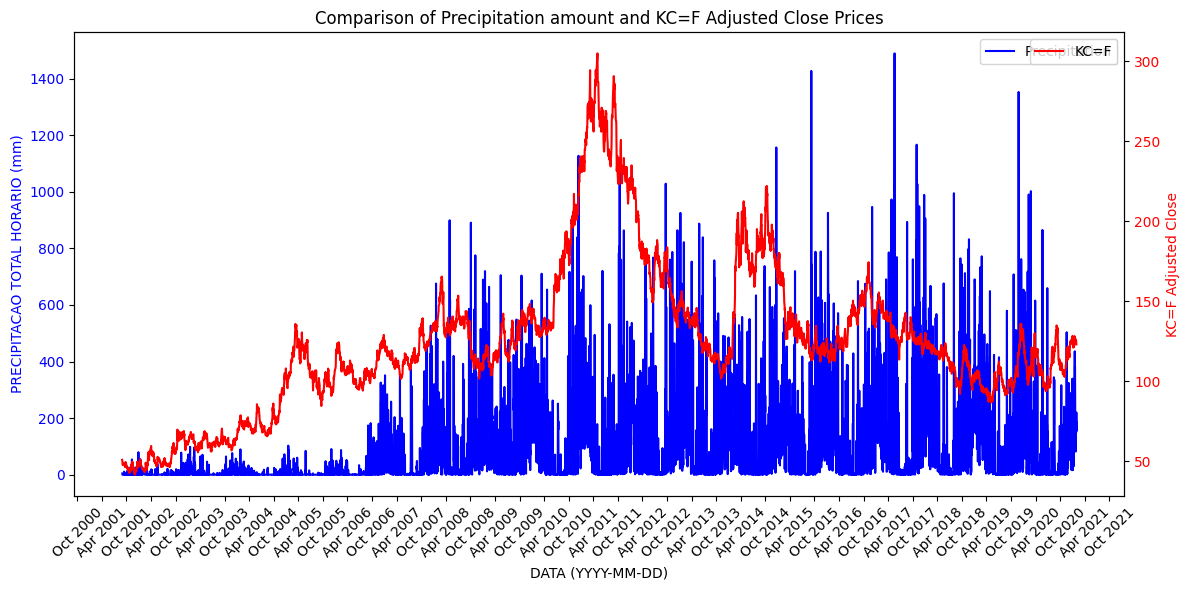

In [307]:
create_correlation_plots('DATA (YYYY-MM-DD)', 'PRECIPITACAO TOTAL HORARIO (mm)', 'Adj Close', 
                        final_day_df, s,
                        'Precipitation', 'KC=F', 
                        'PRECIPITACAO TOTAL HORARIO (mm)', 'KC=F Adjusted Close', 
                        'Comparison of Precipitation amount and KC=F Adjusted Close Prices',
                        'd')

Now lets do it for our greatest positive correlation:

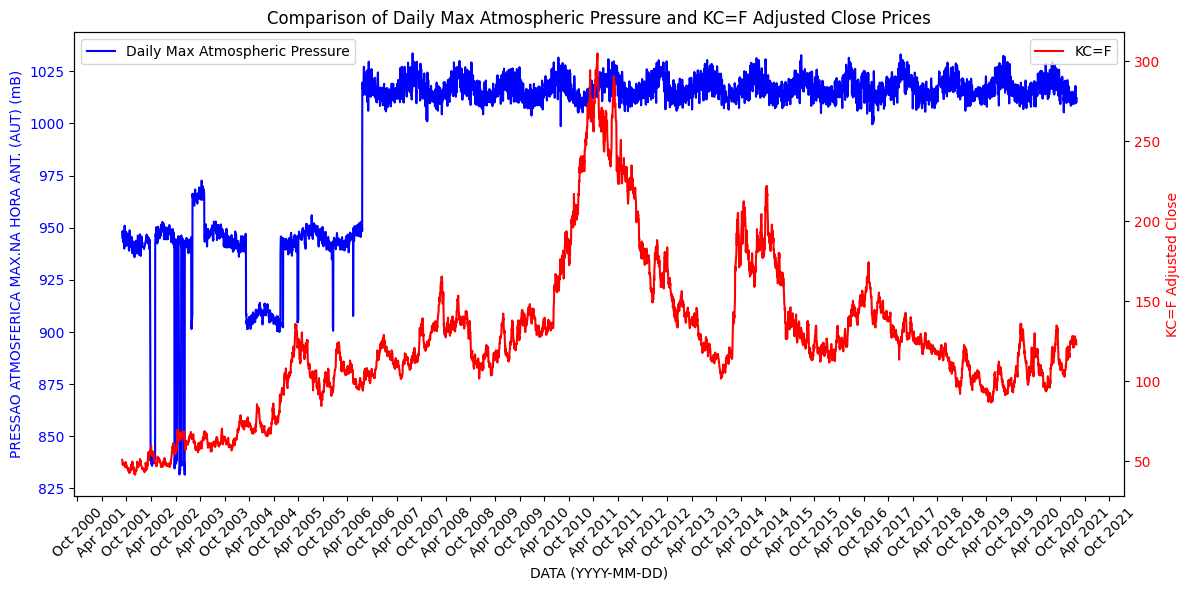

In [308]:
create_correlation_plots('DATA (YYYY-MM-DD)', 'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 'Adj Close', 
                        final_day_df,  s,
                        'Daily Max Atmospheric Pressure', 'KC=F', 
                        'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 'KC=F Adjusted Close', 
                        'Comparison of Daily Max Atmospheric Pressure and KC=F Adjusted Close Prices',
                        'd')

Now lets do it for our greatest negative correlation:

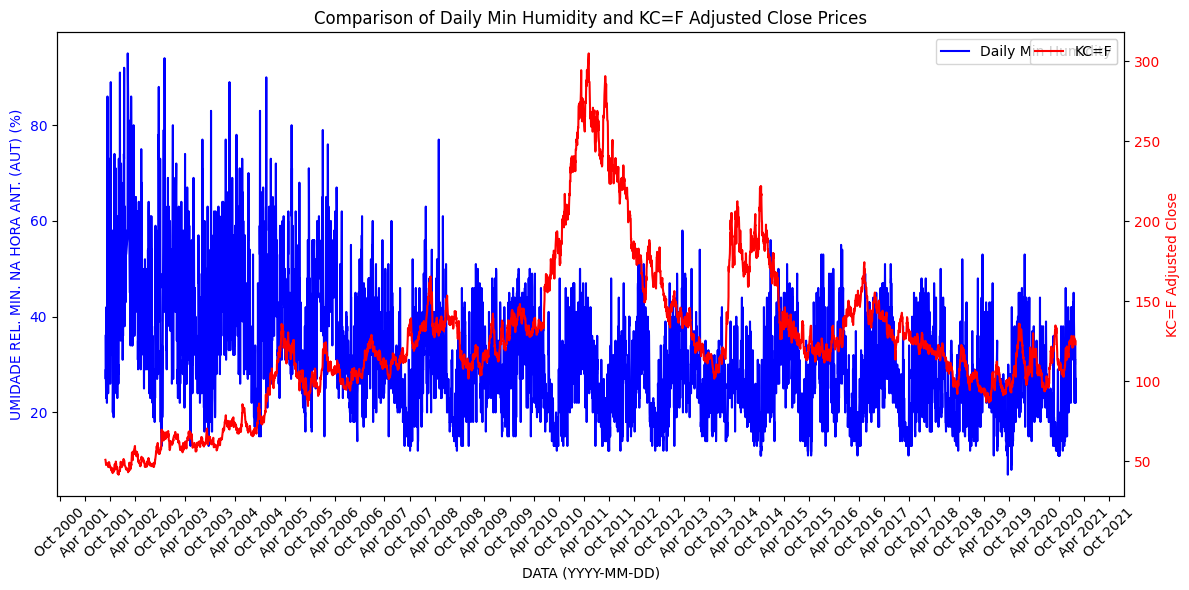

In [309]:
create_correlation_plots('DATA (YYYY-MM-DD)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'Adj Close', 
                        final_day_df, s, 
                        'Daily Min Humidity', 'KC=F', 
                        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'KC=F Adjusted Close', 
                        'Comparison of Daily Min Humidity and KC=F Adjusted Close Prices',
                        'd')

## For Monthly Values

In [310]:
s['YEAR_MONTH'] = s['DATA (YYYY-MM-DD)'].dt.strftime('%Y-%m')
final_month_df['YEAR_MONTH'] = pd.to_datetime(final_month_df['YEAR_MONTH'])

s_month = s.groupby('YEAR_MONTH').agg({'Adj Close': 'max'}).reset_index()
s_month['YEAR_MONTH'] = pd.to_datetime(s_month['YEAR_MONTH'])
s_month.head(5)


,YEAR_MONTH,Adj Close
0,2001-08-01,50.799999
1,2001-09-01,49.150002
2,2001-10-01,47.400002
3,2001-11-01,49.700001
4,2001-12-01,49.599998


PRECIPITACAO TOTAL HORARIO (mm)                          0.364467
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)        -0.165790
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)               -0.257284
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)         -0.219659
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                -0.334435
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0.574636
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0.574710
RADIACAO GLOBAL (W/m2)                                   0.457885
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)              0.377512
TEMPERATURA DO PONTO DE ORVALHO (C)                      0.456503
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                0.372447
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)          0.457489
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0.518092
UMIDADE RELATIVA DO AR, HORARIA (%)                      0.504831
VENTO, DIRECAO HORARIA (gr)                              0.117821
VENTO, RAJ

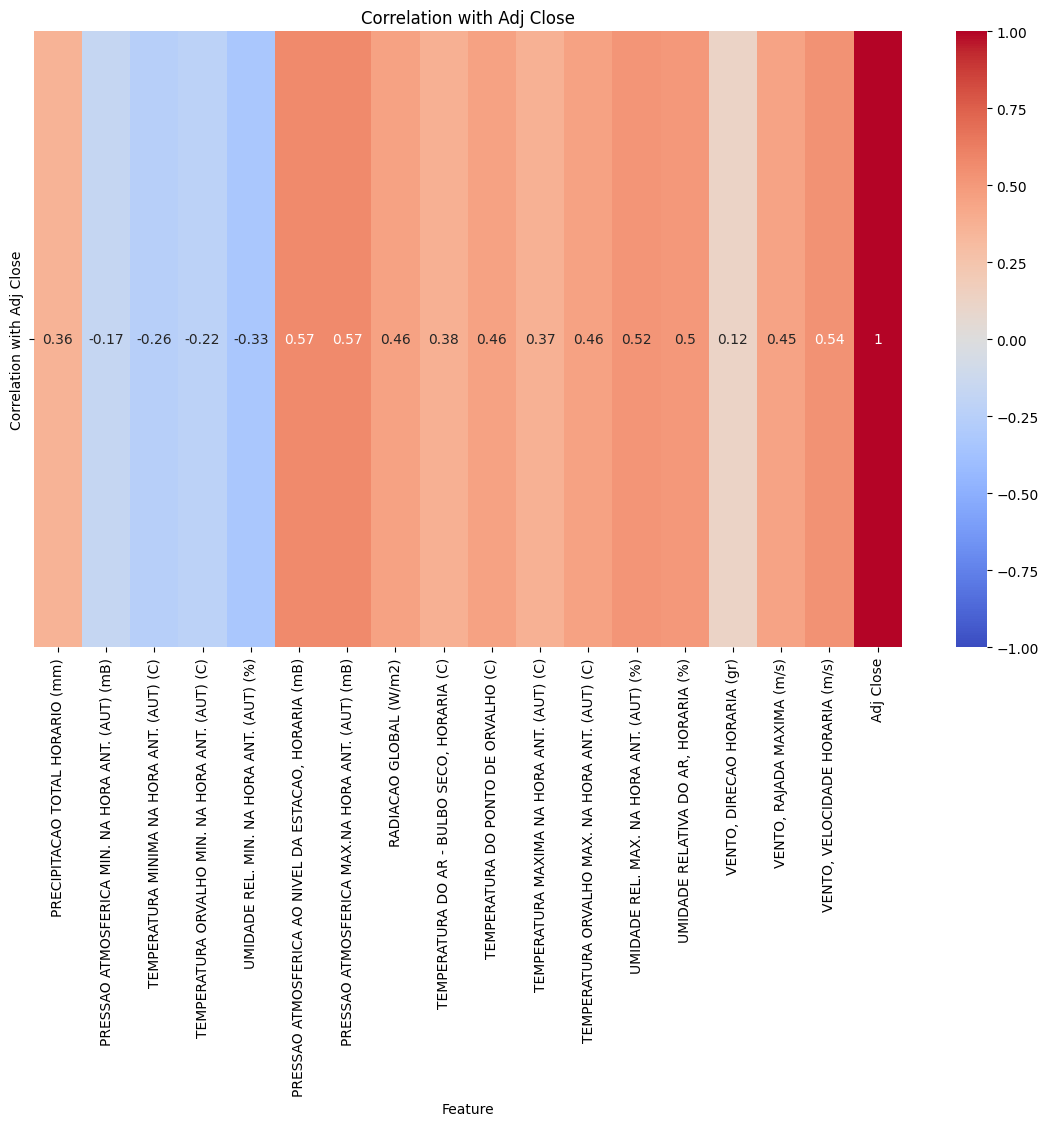

In [311]:

merged_df = pd.merge(final_month_df, s_month, on='YEAR_MONTH', how='inner')  # 'inner' keeps only dates that are in both DataFrames

# Calculate correlation between 'Value' and 'Adj Close'
correlation_matrix = merged_df.drop(columns=['YEAR_MONTH']).corrwith(merged_df['Adj Close'])
print(correlation_matrix)
# Convert Series to DataFrame for easier plotting
correlation_df = correlation_matrix.reset_index()
correlation_df.columns = ['Feature', 'Correlation with Adj Close']

# Create the plot
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df.set_index('Feature').T, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation with Adj Close')
plt.show()

So the best correlations are:
- Positive: 
    - PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB) ---> 0.574636
    - PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB) ---> 0.574710
- Negative: 
    - UMIDADE REL. MIN. NA HORA ANT. (AUT) (%) ---> -0.334435
  
So it seems atmospheric pressure has the highest correlation with coffee futures prices.

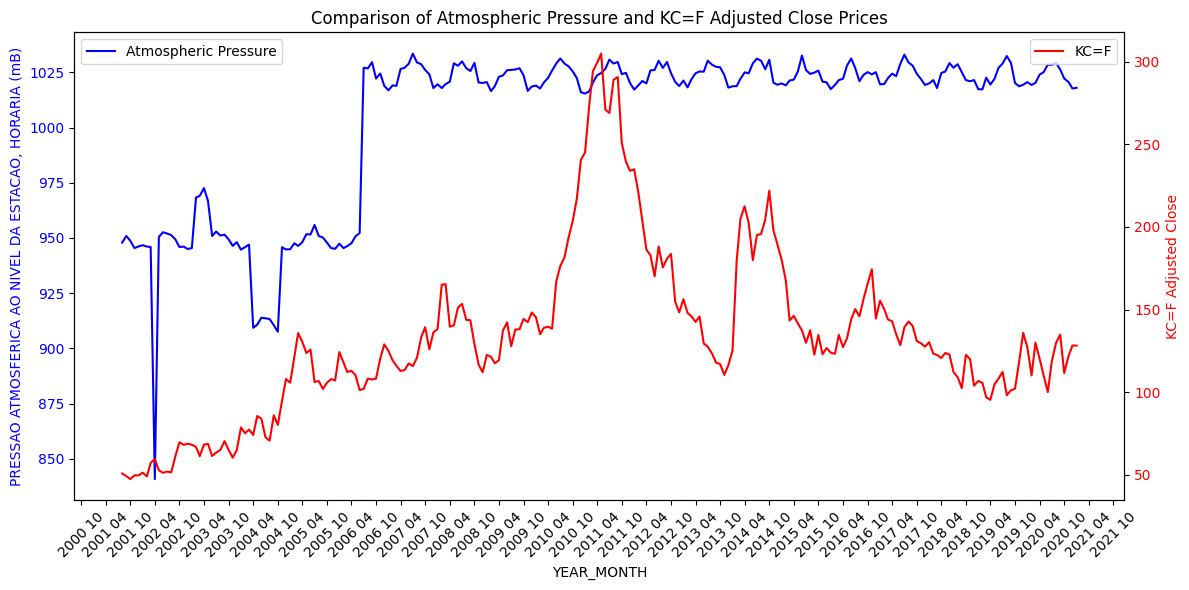

In [312]:
create_correlation_plots('YEAR_MONTH', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', 'Adj Close', 
                        final_month_df,  s_month,
                        'Atmospheric Pressure', 'KC=F', 
                        'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', 'KC=F Adjusted Close', 
                        'Comparison of Atmospheric Pressure and KC=F Adjusted Close Prices', 
                        'm')

## For Yearly Values

In [313]:
# get maximum yearly values for the Futures prices

s['YEAR'] = s['Date'].dt.year

s_year = s.loc[s.groupby('YEAR')['Adj Close'].idxmax()].drop(columns=['Date', 'DATA (YYYY-MM-DD)', 'YEAR_MONTH'])
s_year['YEAR'] = pd.to_datetime(s_year['YEAR'], format="%Y")
s_year.head(5)

,Adj Close,YEAR
0,50.799999,2001-01-01
273,69.699997,2002-01-01
498,70.349998,2003-01-01
821,107.949997,2004-01-01
869,135.750000,2005-01-01


YEAR                                                     0.364719
PRECIPITACAO TOTAL HORARIO (mm)                          0.621030
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)        -0.419916
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)               -0.332159
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)         -0.127769
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                -0.372795
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0.632337
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0.632659
RADIACAO GLOBAL (W/m2)                                   0.710517
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)              0.499590
TEMPERATURA DO PONTO DE ORVALHO (C)                      0.529414
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)                0.533809
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)          0.510862
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0.518078
UMIDADE RELATIVA DO AR, HORARIA (%)                      0.518078
VENTO, DIR

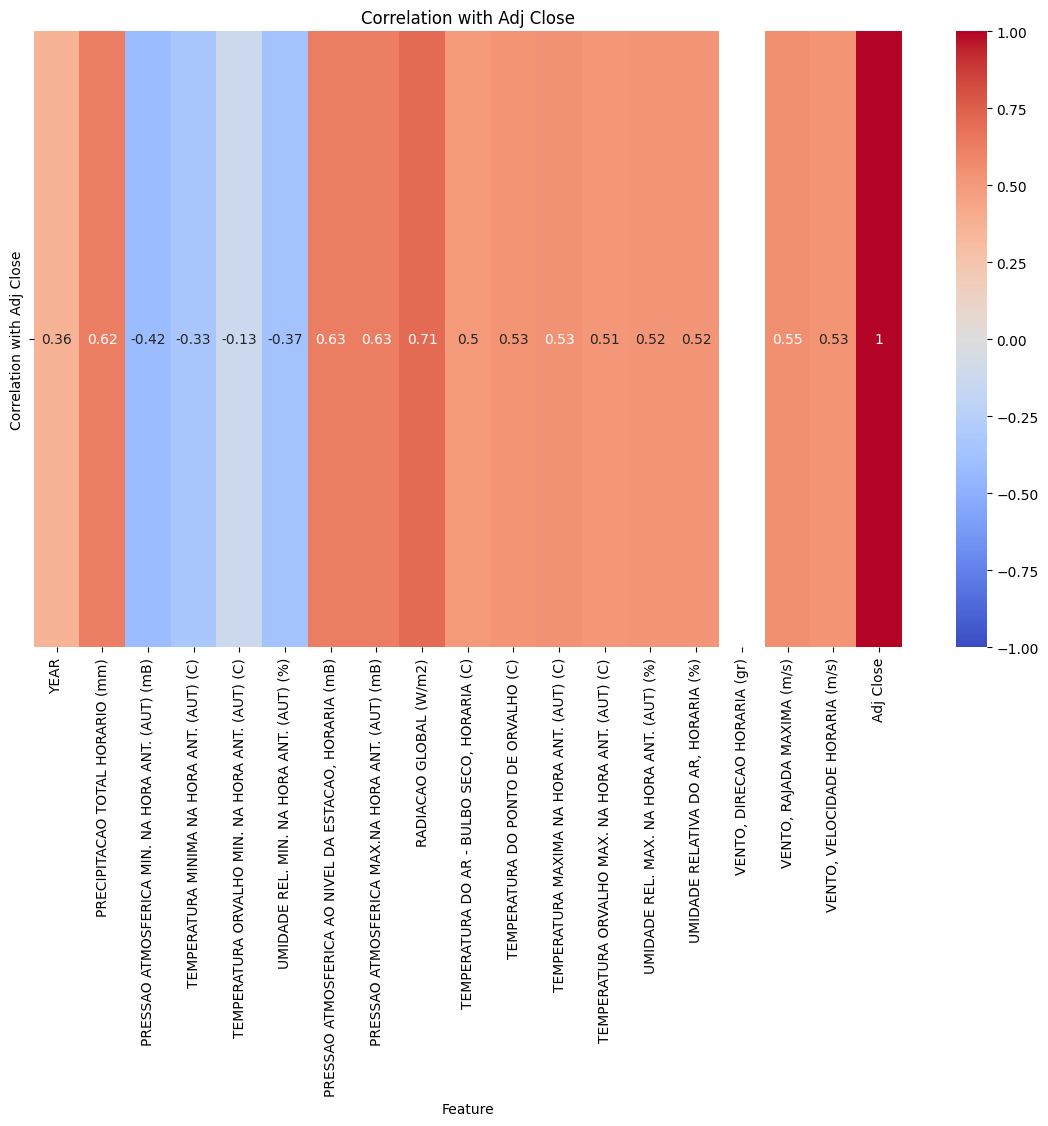

In [314]:
# Merge the two DataFrames on the 'Date' column
merged_df = pd.merge(final_year_df, s_year, on='YEAR', how='inner')  # 'inner' keeps only dates that are in both DataFrames

# Calculate correlation between 'Value' and 'Adj Close'
correlation_matrix = merged_df.corrwith(merged_df['Adj Close'])
print(correlation_matrix)
# Convert Series to DataFrame for easier plotting
correlation_df = correlation_matrix.reset_index()
correlation_df.columns = ['Feature', 'Correlation with Adj Close']

# Create the plot
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_df.set_index('Feature').T, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation with Adj Close')
plt.show()

We can see the correlations are much bigger in the year to year case. This makes a lot of sense since weather does not affect crops immediately.

From now on, we will study the year to year only (again for brevity).

So the best correlations are:
- Positive: 
    - PRECIPITACAO TOTAL HORARIO (mm) ---> 0.570880
    - PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB) ---> 0.588777
    - RADIACAO GLOBAL (W/m2) ---> 0.587680
- Negative: are all too small for us in this case
  
So it seems precipitation, atmospheric pressure and global radiation, have the highest correlation with coffee futures prices.

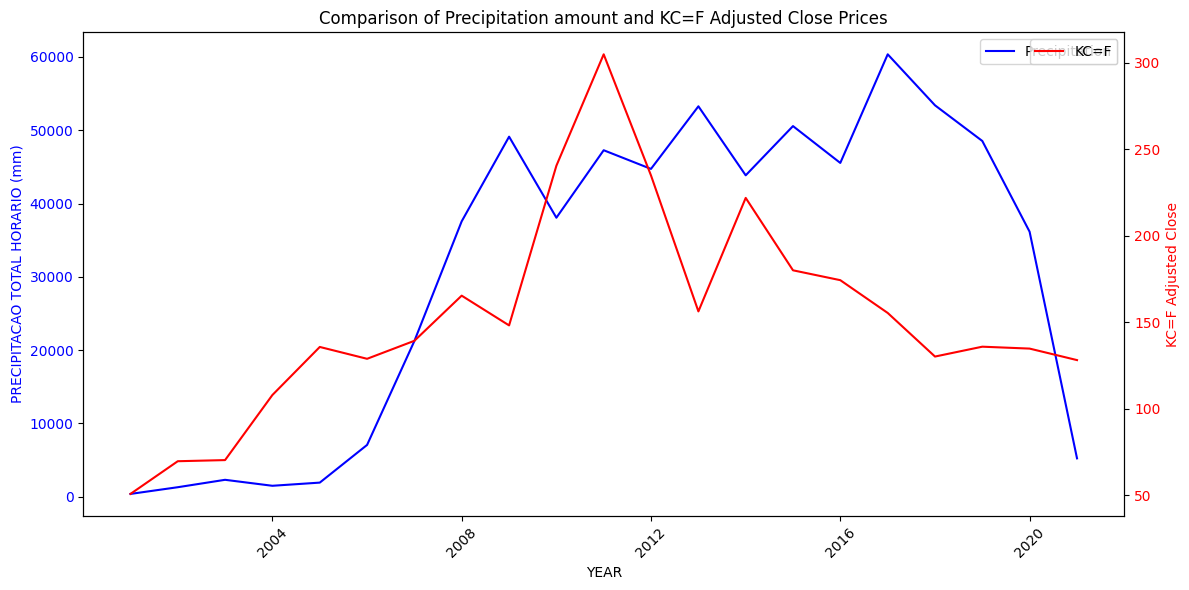

In [315]:
create_correlation_plots('YEAR', 'PRECIPITACAO TOTAL HORARIO (mm)', 'Adj Close', 
                        final_year_df, s_year,
                        'Precipitation', 'KC=F', 
                        'PRECIPITACAO TOTAL HORARIO (mm)', 'KC=F Adjusted Close', 
                        'Comparison of Precipitation amount and KC=F Adjusted Close Prices', 
                        'y')

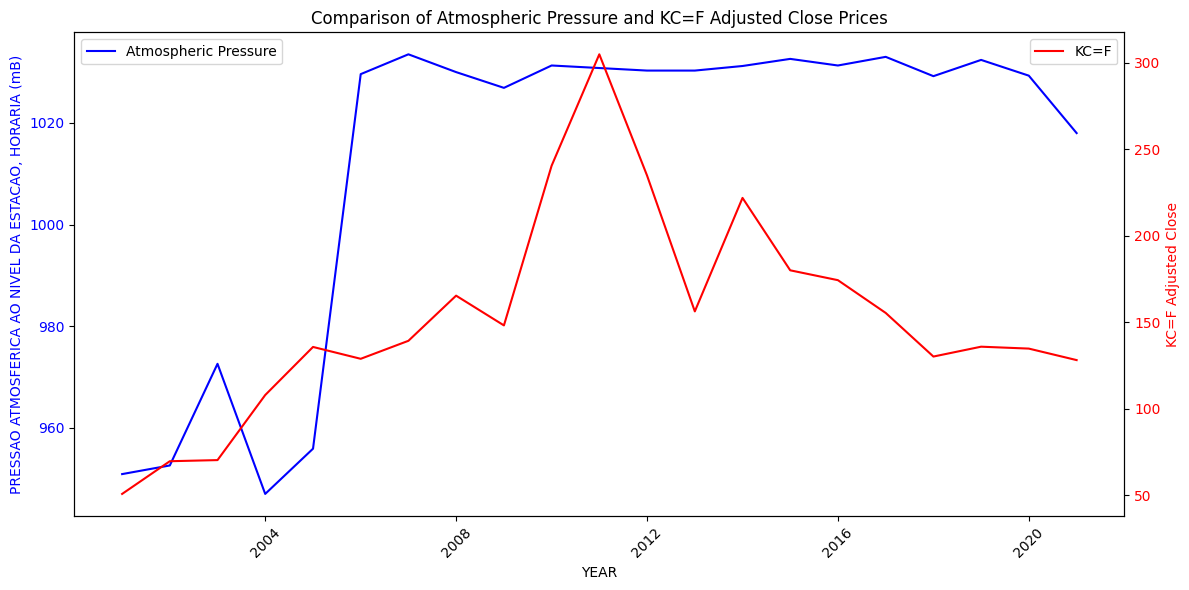

In [316]:
create_correlation_plots('YEAR', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', 'Adj Close', 
                        final_year_df, s_year,
                        'Atmospheric Pressure', 'KC=F', 
                        'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', 'KC=F Adjusted Close', 
                        'Comparison of Atmospheric Pressure and KC=F Adjusted Close Prices', 
                        'y')

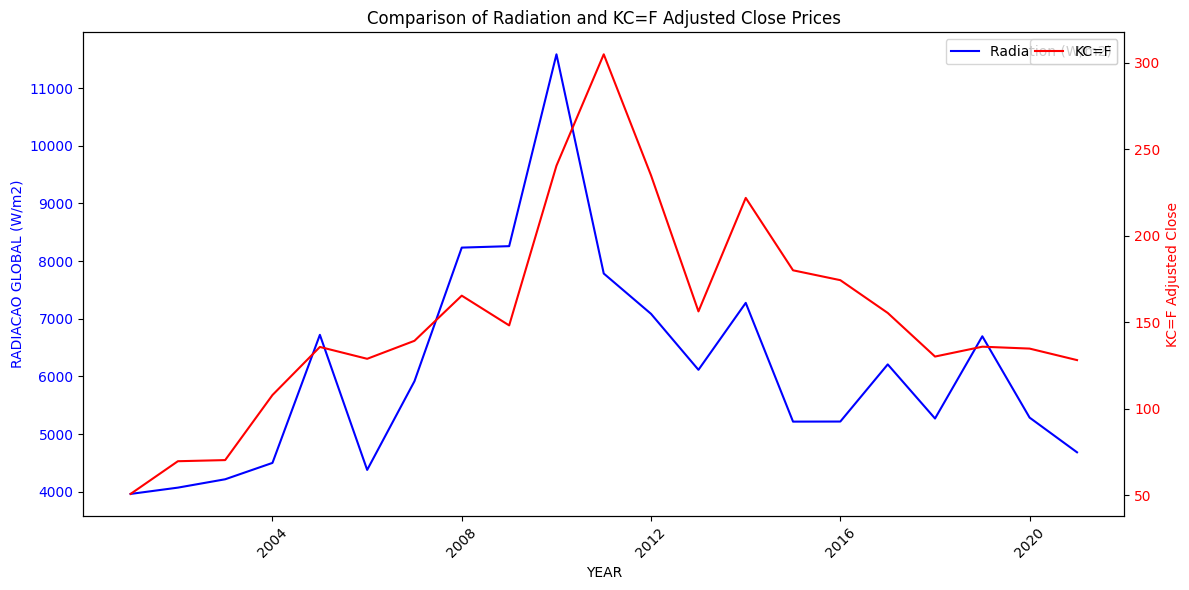

In [317]:
create_correlation_plots('YEAR', 'RADIACAO GLOBAL (W/m2)', 'Adj Close', 
                        final_year_df, s_year,
                        'Radiation (W/m2)', 'KC=F', 
                        'RADIACAO GLOBAL (W/m2)', 'KC=F Adjusted Close', 
                        'Comparison of Radiation and KC=F Adjusted Close Prices', 
                        'y')

Conclusions:
- Data pre 2005 seems inconsistent with the rest of it. A greater study and data cleaning should be done to access this;
- Radiation amount, at least visually, seems to be the most correlated with coffee future prices, so this is the one we will use 
- Year comparison presents higher correlations, but in futures it is more appropriate to think in months, so that is what we will use

## Clean up Data to Use in Trading Strategy

In [318]:
# Get only data after 2007 because that prior to that, the data seems unreliable
start_date = '2007-01-01'

mask = (final_month_df['YEAR_MONTH'] > start_date)
secure_weather_data =final_month_df.loc[mask] 
secure_weather_data["YEAR_MONTH_OG"] = secure_weather_data["YEAR_MONTH"]

mask = (s_month['YEAR_MONTH'] > start_date)
secure_coffee_data = s_month.loc[mask]

secure_coffee_data["YEAR_MONTH_OG"] = secure_coffee_data["YEAR_MONTH"]
secure_coffee_data["YEAR_MONTH"] = (
    secure_coffee_data["YEAR_MONTH"].values.astype("datetime64[M]") 
    + 2
)

In [319]:
secure_coffee_data.head(5)

,YEAR_MONTH,Adj Close,YEAR_MONTH_OG
66,2007-04-01,119.250000,2007-02-01
67,2007-05-01,116.000000,2007-03-01
68,2007-06-01,112.849998,2007-04-01
69,2007-07-01,113.349998,2007-05-01
70,2007-08-01,117.400002,2007-06-01


PRECIPITACAO TOTAL HORARIO (mm)                          0.019228
PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)        -0.152012
TEMPERATURA MINIMA NA HORA ANT. (AUT) (C)               -0.042480
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (C)          0.076361
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                 0.057559
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0.018015
PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0.017167
RADIACAO GLOBAL (W/m2)                                   0.255445
TEMPERATURA DO AR - BULBO SECO, HORARIA (C)             -0.075654
TEMPERATURA DO PONTO DE ORVALHO (C)                     -0.006587
TEMPERATURA MAXIMA NA HORA ANT. (AUT) (C)               -0.103816
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (C)         -0.021994
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0.055307
UMIDADE RELATIVA DO AR, HORARIA (%)                      0.051182
VENTO, DIRECAO HORARIA (gr)                                   NaN
VENTO, RAJ

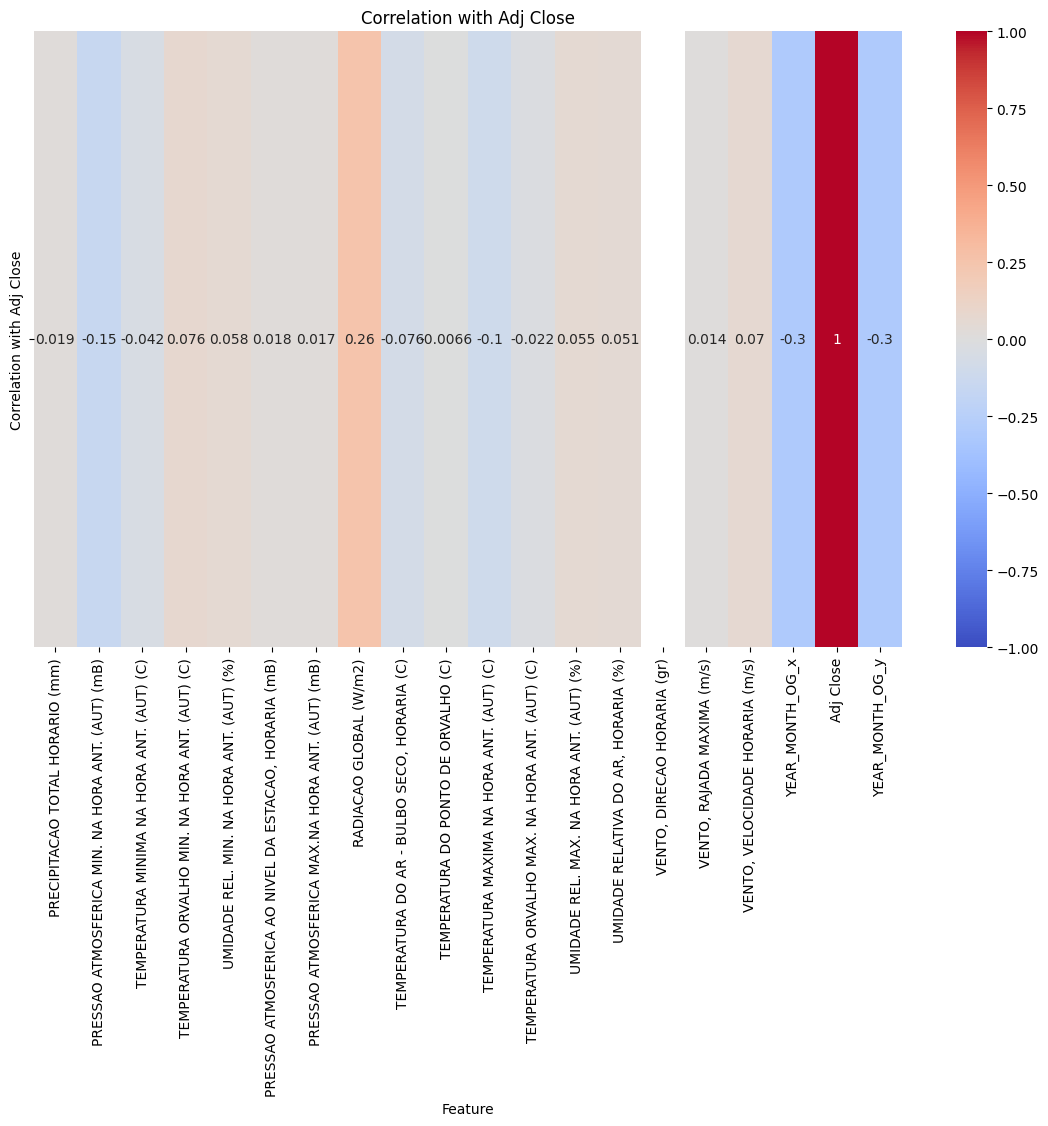

In [320]:
# Get correlation matrix for this newly filtered data
clean_merged_df = pd.merge(secure_weather_data, secure_coffee_data, on='YEAR_MONTH', how='inner')  # 'inner' keeps only dates that are in both DataFrames

# Calculate correlation between 'Value' and 'Adj Close'
clean_correlation_matrix = clean_merged_df.drop(columns=['YEAR_MONTH']).corrwith(clean_merged_df['Adj Close'])
print(clean_correlation_matrix)
# Convert Series to DataFrame for easier plotting
clean_correlation_df = clean_correlation_matrix.reset_index()
clean_correlation_df.columns = ['Feature', 'Correlation with Adj Close']

# Create the plot
plt.figure(figsize=(14, 8))
sns.heatmap(clean_correlation_df.set_index('Feature').T, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation with Adj Close')
plt.show()

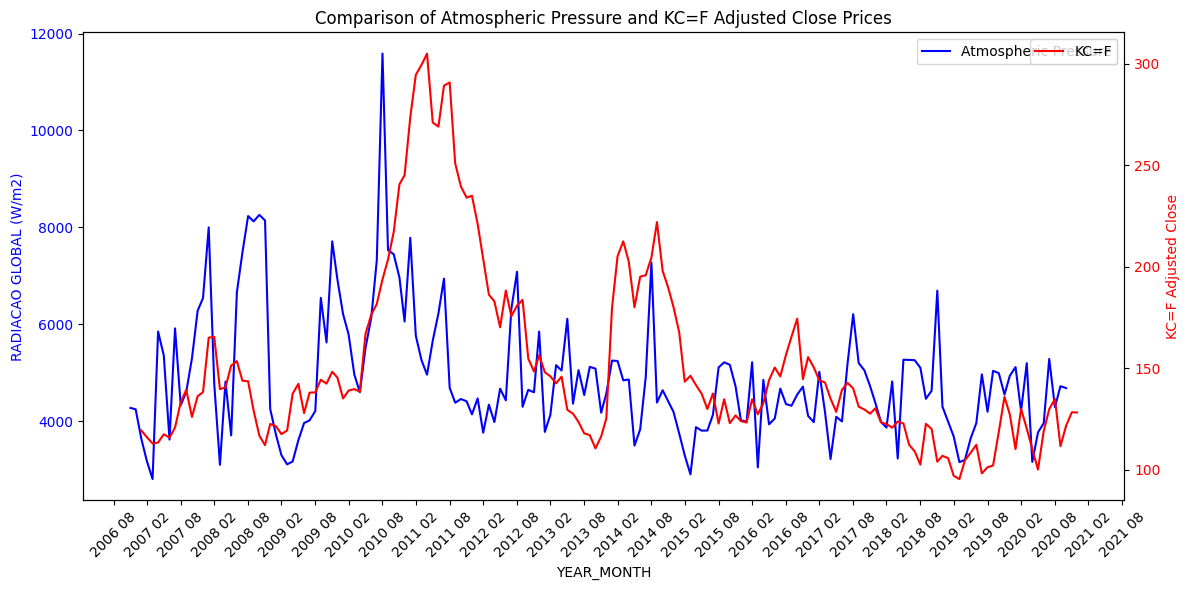

In [321]:
create_correlation_plots('YEAR_MONTH', 'RADIACAO GLOBAL (W/m2)', 'Adj Close', 
                        secure_weather_data,  secure_coffee_data,
                        'Atmospheric Pressure', 'KC=F', 
                        'RADIACAO GLOBAL (W/m2)', 'KC=F Adjusted Close', 
                        'Comparison of Atmospheric Pressure and KC=F Adjusted Close Prices', 
                        'm')

In [322]:
# Save the data
secure_weather_data.to_csv('FilteredData/secure_weather.csv', sep=';', index=False)
secure_coffee_data.to_csv('FilteredData/secure_coffee.csv', sep=';', index=False)